In [1]:
pickle_rel_path = '../datasets/notmnist/notMNIST.pickle'
import os
import pickle
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.python.framework import ops

### Import data

In [2]:
# Discover pickle path
file_dir = os.path.dirname(os.path.realpath('__file__'))
pickle_path = os.path.abspath(os.path.join(file_dir, pickle_rel_path))
print('Pickle location:',pickle_path)

# Load pickle
with open(pickle_path,'rb') as file:
    datasets = pickle.load(file)
print(datasets.keys())

# Set variables
train_dataset = datasets['train_dataset']
orig_train_labels = datasets['train_labels'] 
validate_dataset = datasets['valid_dataset']
orig_validate_labels = datasets['valid_labels'] 
test_dataset = datasets['test_dataset']
orig_test_labels = datasets['test_labels'] 

# Convert labels representation
num_labels = 10
def setup_labels(label_array, num_labels):
    return ((np.arange(num_labels) == label_array[:,None]).astype(np.float32))
train_labels = setup_labels(orig_train_labels, num_labels)
validate_labels = setup_labels(orig_validate_labels, num_labels)
test_labels = setup_labels(orig_test_labels, num_labels)

Pickle location: C:\Users\lgess\Documents\repo\learning_ai\datasets\notmnist\notMNIST.pickle
dict_keys(['test_dataset', 'train_labels', 'test_labels', 'valid_dataset', 'train_dataset', 'valid_labels'])


### Normalize data

Pre-normalized

### Define model

In [101]:
class Layer:
    
    def __init__(self, w_shape, b_shape, name=""):
        self.name = name    
        self.w_shape = w_shape
        self.b_shape = b_shape
        
    def create_vars(self):
        with tf.name_scope(self.name):
            initializer = tf.glorot_normal_initializer()
            self.w = tf.get_variable(name="W"+self.name, shape=self.w_shape, dtype=tf.float32, initializer=initializer)
            self.b = tf.get_variable(name="B"+self.name, shape=self.b_shape, dtype=tf.float32, initializer=initializer)  
    
    def weighted_inputs(self, x): 
        with tf.name_scope(self.name):
            return tf.matmul(x, tf.transpose(self.w))+self.b
    
    def inference(self, x):
        raise NotImplementedError()

    def training(self, x, y):
        raise NotImplementedError()

class HiddenLayer(Layer):       
        
    def inference(self, x):
        with tf.name_scope(self.name):
             return tf.nn.relu(self.weighted_inputs(x))
            
    def training(self, x, y, keep_prob):
        with tf.name_scope(self.name):
            x = tf.cond(keep_prob<1, lambda: tf.nn.dropout(x, keep_prob), lambda: x)
            return self.inference(x)
                          
class OutputLayer(Layer):
        
    def inference(self, x):
        with tf.name_scope(self.name):
            logits = self.weighted_inputs(x)
            return tf.nn.softmax(logits)
                             
    def training(self, x, y, keep_prob):
        with tf.name_scope(self.name):
            #x = tf.nn.dropout(x, keep_prob)
            logits = self.weighted_inputs(x)
            cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y)
            loss = tf.reduce_mean(cross_entropy)
            return loss
        
class Model:
                          
    def __init__(self, layers, name=""):
        self.name = name
        self.layers = layers   
        
    def create_vars(self):
        for layer in self.layers:
            layer.create_vars()
                          
    def inference(self, x):
        for layer in self.layers:
            x = layer.inference(x)
        return x
                          
    def loss(self, x, y, keep_prob, regularization):
        l2 = 0
        for layer in self.layers:
            x = layer.training(x, y, keep_prob)
            l2_reg = l2 + tf.nn.l2_loss(layer.w)/tf.cast(tf.size(layer.w),tf.float32)
            l2 = tf.cond(regularization > 0, lambda: l2_reg, lambda: 0.0)
        return x + regularization*l2
    
def create_simple_classifier(features_shape, num_neurons_array, num_labels):
                            
    layers = []    
    w_shape = None
    b_shape = features_shape
    index = 1

    for num_neurons in num_neurons_array:
        w_shape = np.append([num_neurons],b_shape)
        b_shape = [num_neurons]
        layers.append(HiddenLayer(w_shape, b_shape, name="Layer"+str(index)))
        index+=1

    w_shape = np.append([num_labels],b_shape)
    b_shape = [num_labels]
    layers.append(OutputLayer(w_shape, b_shape, name="Layer"+str(index))) 

    return Model(layers=layers)

In [102]:
class SessionRunner:
    
    def __init__(self, features_shape, num_neurons_array, num_labels):
        self.graph = tf.Graph()
        with self.graph.as_default():
            self.session = tf.Session(config=tf.ConfigProto(log_device_placement=True))
            self.x = tf.placeholder(dtype=tf.float32,shape=np.append(None,features_shape), name="x")
            self.y = tf.placeholder(dtype=tf.float32,shape=np.append(None,[num_labels]), name="y")
            self.keep_prob = tf.placeholder(dtype=tf.float32,shape=[], name="keep_prob")
            self.regularization = tf.placeholder(dtype=tf.float32,shape=[], name="regularization")
            model = create_simple_classifier(features_shape, num_neurons_array, num_labels)
            model.create_vars()
            self.inference = model.inference(self.x)
            self.loss = model.loss(self.x,self.y,self.keep_prob,self.regularization)

    def train(self, train_dataset, train_labels, 
              batch_size=200, learning_rate=0.5, iterations=1000, keep_prob=0.75, regularization=0):
        
        index = 0
        num_data = len(train_dataset)
        if batch_size > num_data:
            batch_size = num_data
        
        with self.graph.as_default():
            init = tf.global_variables_initializer()
            optimizer = tf.train.GradientDescentOptimizer(learning_rate)
            step = optimizer.minimize(self.loss, name="Optimizer")  
        
        self.session.run(init)
        
        for i in range(iterations):   
            if 2*batch_size < num_data:
                index = (i*batch_size)%(len(train_dataset)-batch_size)
            feed_dict={self.x: train_dataset[index:index+batch_size], 
                       self.y: train_labels[index:index+batch_size],
                       self.keep_prob: keep_prob,
                       self.regularization: regularization}      
            self.session.run(step, feed_dict)
            if i%(iterations/10) == 0:
                loss_value = self.session.run(self.loss, feed_dict)
                print(loss_value)
                
    def predict(self, dataset):
        return self.session.run(self.inference, feed_dict={self.x: dataset})
        
    def evaluate(self, dataset, labels):
        print(self.__accuracy(predicted=self.predict(dataset), expected=labels))
        
    def __accuracy(self, predicted, expected):
        return np.mean(np.argmax(predicted,1) == np.argmax(expected,1))
        

### Train model

In [163]:
features_shape = train_dataset.shape[1:]
num_features = features_shape[0]*features_shape[1]

try:
    session_runner.session.close()
except:
    None
session_runner = SessionRunner(features_shape=[num_features], 
                               num_neurons_array = [100,100,100,100],
                               num_labels = (10))
num_samples = 200
session_runner.train(train_dataset.reshape([-1,num_features])[0:num_samples], train_labels[0:num_samples], 
                     batch_size=10, learning_rate=0.2, iterations=5000, keep_prob=0.9, regularization=10) #batch=1000
writer = tf.summary.FileWriter("/tf.log", session_runner.graph)

2.2356555
0.23251127
0.2479821
0.14364482
0.12980384
0.117294915
0.11538116
0.0962862
0.08884112
0.08469728


### Evaluate Model

In [164]:
session_runner.evaluate(train_dataset.reshape([-1,num_features])[0:num_samples], train_labels[0:num_samples])
session_runner.evaluate(validate_dataset.reshape([-1,num_features]), validate_labels)
session_runner.evaluate(test_dataset.reshape([-1,num_features]), test_labels)

0.99
0.7438
0.8153


### Test sample

Label: 3


3

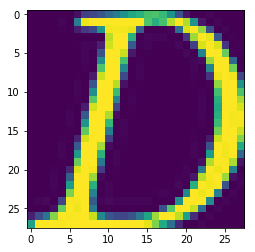

In [53]:
def show_sample(sample_image, label):
    plt.figure()
    plt.imshow(sample_image)
    print('Label:', np.argmax(label))

index=0
show_sample(validate_dataset[index],validate_labels[index])
np.argmax(session_runner.predict([validate_dataset[index].reshape([num_features])]))